# Footfall data downloaded from the City of Melbourne's Open Data Website:  
### https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp
#### By selecting Export --> CSV
##### Check where I downloaded the sensor location data from

#### Code initialisation

In [5]:
import pandas as pd
import numpy as np
# import seaborn as sns
import os
os.getcwd()

'/nfs/a319/gy17m2a/Project/Footfall/Scripts/MelbourneAnalysis'

#### Import pedestrian count data

In [6]:
sensor_counts = pd.read_csv('Data/Pedestrian_Counting_System_-_Monthly__counts_per_hour_.csv')
sensor_locations = pd.read_csv('Data/melbourne_locations.csv')

#### Rename columns to all lowercase (to facilitate joining)

In [7]:
sensor_counts.rename({'Date_Time': 'datetime', 'Year': 'year', 'Month':'month', 'Mdate': 'mdate', 
                      'Day': 'day', 'Time': 'time', 'Sensor_ID': 'sensor_id', 'Hourly_Counts': 'hourly_counts'}, 
                     axis = 1, inplace = True)

#### Drop unneeded columns

In [8]:
sensor_counts.drop(['ID', 'Sensor_Name'], axis = 1, inplace = True)
sensor_locations.drop(['sensor_description', 'sensor_name', 'installation_date', 'status', 'note', 'direction_1',
                      'direction_2'], axis = 1, inplace = True)

#### Join two dataframes so location and count info in same place

In [9]:
location_counts = pd.merge(sensor_locations, sensor_counts, on='sensor_id', how='inner')

#### It could be useful to drop sensors that do not have as many recorded countsfor now leaving them in, but may drop in the future

In [37]:
# location_counts.sensor_id.value_counts().sort_values()[:20]

#### Removing sensors without complete enough data

In [32]:
# # Get data for just one sensor
# one_sensor =  location_counts[location_counts.sensor_id == 17]
# # Create an index containing all the dates between the first and last date for this sensor
# idx = pd.date_range(min(one_sensor['datetime']), max(one_sensor.datetime), freq = 'H')
# # Set the datetime as the index
# one_sensor.set_index('datetime', inplace = True)
# # Check if the lenth of the index containing all the datetimes between the start and end is the same length as the df:
# print("len idx: ", len(idx), "len data:" ,len(one_sensor))
# if len(idx) != len(one_sensor):
#     # Reindex using the idx, and where there are gaps apply np.nan as the value
#     test = one_sensor.reindex(idx, fill_value=np.nan)
#     test[test['person'].isna()]
#         # Shows duplicated values for the same timestamp
#         # Seems to be that all sensors have duplicated values for September 2010
#         # check whether its just that they havennt had timestamps assigned properly - e.g. all set as 12Am when they should have hours
#         # for now, could just 
#         one_sensor[one_sensor.index.duplicated()][0:50]

#### List the number of missing hours in each year of data for each sensor

In [367]:
# pd.DataFrame(yearly_missing_vals, index=yearly_missing_vals.keys())
yearly_missing_vals

df = pd.DataFrame.from_dict(yearly_missing_vals, orient='index', columns = [sensor_number])
df

d
2011     0
2012     0
2013     1
2014     1
2015     1
2016     1
2017  3096
2018   264
2019     0
2020     0
2021     0
2022  2928

In [397]:
def check_sensor_data_completeness(sensor_number):
    
    # Get data for just one sensor
    one_sensor =  location_counts[location_counts.sensor_id == sensor_number]

    # Go for only years after 2010 where messed up data is
    one_sensor = one_sensor[one_sensor.year >2010]
    one_sensor = one_sensor.sort_values(by=['datetime'])

    yearly_missing_vals = {}
    for year in np.sort(one_sensor.year.unique()):
        one_year = one_sensor[one_sensor.year==year]
        vals_this_year = len(one_year)
        expected_vals_this_year = len(pd.date_range(date(year, 1, 1), datetime(year, 12, 31, 23), freq = 'H'))
        yearly_missing_vals[year] = expected_vals_this_year - vals_this_year
    
    # Convert to dataframe
    yearly_missing_vals_df = pd.DataFrame.from_dict(yearly_missing_vals, orient='index', columns = [sensor_number])
    
    return yearly_missing_vals_df

In [396]:
def check_sensor_data_completeness(sensor_number):
    
    # Get data for just one sensor
    one_sensor =  location_counts[location_counts.sensor_id == sensor_number]

    # Go for only years after 2010 where messed up data is
    one_sensor = one_sensor[one_sensor.year >2010]
    one_sensor = one_sensor.sort_values(by=['datetime'])

    # Convert date to datetime
    one_sensor['datetime'] =  pd.to_datetime(one_sensor['datetime'])
    # Sort values by datetime
    one_sensor.sort_values(by='datetime', ascending=True, inplace=True)
    
    # Set the datetime as the index
    one_sensor.set_index('datetime', inplace = True)

    ##############################################
    # Determine the date of the first/last day in the first year for which data is included
    first_day = date(min(one_sensor.index).year, 1, 1)
    last_day = date(max(one_sensor.index).year, 12, 31)
    
    # Create a series containing all the dates between the first and last date for this sensor
    date_range = pd.date_range(first_day, last_day, freq = 'H')
    
    # Reindex using the date range, and where there are gaps apply np.nan as the value
    one_sensor = one_sensor.reindex(date_range, fill_value=np.nan)
    
    ##############################################
    # Find all the years which contain some NA values (i.e. they had missing vlaues)
    missing_values = one_sensor[one_sensor['hourly_counts'].isna()]
    # years_with_missing_values = missing_values.index.year
    
    # Find the number of missing values in each year
    years, counts = np.unique(missing_values.index.year, return_counts = True)
    missing_vals_per_year = pd.DataFrame({'Year': years, 'Counts': counts})
    
    return missing_vals_per_year

In [403]:
# missing_vals_per_year_all_sensors_old = missing_vals_per_year_all_sensors.copy()
missing_vals_per_year_all_sensors

1
2011  8472
2012     0
2013     1
2014  1105
2015  1129
2016     1
2017     1
2018     0
2019   144
2020     0
2021   216
2022  2928

In [406]:
missing_vals_per_year_all_sensors

1     2     3     4     5     6     7     8     9     10  ...      73  \
2011  8472     0    24     0     0     0     0     0     0   432  ...     NaN   
2012     0     0     0     0     0     0     0     0     0     0  ...     NaN   
2013     1     1     1     1     1     1   409     1     1     1  ...     NaN   
2014  1105     1     1   337     1     1  5664     1     1     1  ...     NaN   
2015  1129     1     1     1     1     1  1609   193     1     1  ...     NaN   
2016     1     1  2208  2184     1     1  1369    19     4    11  ...     NaN   
2017     1     1   577  3649  3096     1   433   433     1     1  ...     NaN   
2018     0     0   768     0   264   433    24     0     0     0  ...     NaN   
2019   144   240   802     0     0     0  2352   504     0     0  ...     NaN   
2020     0     0   120     0     0     0     0   312     0     0  ...  8040.0   
2021   216     0   504     0     0     1     0     0     0   120  ...  7272.0   
2022  2928  2928  2928  5880  2928  2928  8112  2928  3191  2928  ...  7344.0   

          75      76      77      78      79      84      85      86      87  
2011     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2012     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2013     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2014     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2015     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2016     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2017     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2018     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2019     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2020     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2021   744.0  1416.0  2880.0  2880.0  6073.0     NaN     NaN     NaN     NaN  
2022  2928.0  2928.0  2928.0  2928.0  3191.0  2928.0  2928.0  3287.0  7272.0  

[12 rows x 82 columns]

In [405]:
# Inititalise a dataframe to store the number of missing values in each year across all sensors
missing_vals_per_year_all_sensors = None
sensor_numbers_sorted =  sorted(location_counts['sensor_id'].unique().tolist())

# Loop through each sensor
for sensor_number in sensor_numbers_sorted:
    # Return a dataframe containing the number of missing values in each year
    missing_vals_per_year_this_sensor = check_sensor_data_completeness(sensor_number)
    # Rename column with sensor number
    #missing_vals_per_year_this_sensor.rename(columns={"Counts":sensor_number }, inplace = True)
    # Use this as the df for all sensors, if that dataframe does not yet have any content
    if missing_vals_per_year_all_sensors is None:
        missing_vals_per_year_all_sensors = missing_vals_per_year_this_sensor
    # If the df for all sensors is already populated, then join the extra data for this sensor on to it
    else:
        missing_vals_per_year_all_sensors = pd.concat([missing_vals_per_year_all_sensors, missing_vals_per_year_this_sensor], axis=1)

In [247]:
# missing_vals_per_year_this_sensor.rename(columns={"Counts":sensor_number }, inplace = True)
# missing_vals_per_year_this_sensor
# column_names=location_counts['sensor_id'].unique().tolist()
# column_names.insert(0, missing_vals_per_year_all_sensors.columns[0])
missing_vals_per_year_all_sensors
# missing_vals_per_year_all_sensors.columns = column_names
# missing_vals_per_year_all_sensors = missing_vals_per_year_all_sensors.sort_values('Year')
# missing_vals_per_year_all_sensors.reset_index(inplace=True, drop=True)
# missing_vals_per_year_all_sensors

Year       1       2       3       4       5       6       7       8  \
0   2011  8472.0     NaN    24.0     NaN     NaN     NaN     NaN     NaN   
1   2013     1.0     1.0     1.0     1.0     1.0     1.0   409.0     1.0   
2   2014  1105.0     1.0     1.0   337.0     1.0     1.0  5664.0     1.0   
3   2015  1129.0     1.0     1.0     1.0     1.0     1.0  1609.0   193.0   
4   2016     1.0     1.0  2208.0  2184.0     1.0     1.0  1369.0    19.0   
5   2017     1.0     1.0   577.0  3649.0  3096.0     1.0   433.0   433.0   
6   2019   144.0   240.0   802.0     NaN     NaN     NaN  2352.0   504.0   
7   2021   216.0     NaN   504.0     NaN     NaN     1.0     NaN     NaN   
8   2022  2905.0  2905.0  2905.0  5857.0  2905.0  2905.0  8089.0  2905.0   
9   2018     NaN     NaN   768.0     NaN   264.0   433.0    24.0     NaN   
10  2020     NaN     NaN   120.0     NaN     NaN     NaN     NaN   312.0   
11  2012     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

         9  ...      73      75      76      77      78      79      84  \
0      NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1      1.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2      1.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3      1.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4      4.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5      1.0  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
6      NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
7      NaN  ...  7272.0   744.0  1416.0  2880.0  2880.0  6073.0     NaN   
8   3168.0  ...  7321.0  2905.0  2905.0  2905.0  2905.0  3168.0  2905.0   
9      NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
10     NaN  ...  8040.0     NaN     NaN     NaN     NaN     NaN     NaN   
11     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

        85      86      87  
0      NaN     NaN     NaN  
1      NaN     NaN     NaN  
2      NaN     NaN     NaN  
3      NaN     NaN     NaN  
4      NaN     NaN     NaN  
5      NaN     NaN     NaN  
6      NaN     NaN     NaN  
7      NaN     NaN     NaN  
8   2905.0  3264.0  7249.0  
9      NaN     NaN     NaN  
10     NaN     NaN     NaN  
11     NaN     NaN     NaN  

[12 rows x 83 columns]

### Looking at trends in sensor counts
Look to see which sensors have valid records for a full calendar year at a time. Some sensors were added at later years, and some stop working at points throughout the year

In [147]:
sensor_df = location_counts[location_counts.year == 2013]
sensor_df

sensor_id   Latitude   Longitude                      location  \
31626           16 -37.815734  144.965210  (-37.81573422, 144.96521044)   
31627           16 -37.815734  144.965210  (-37.81573422, 144.96521044)   
31628           16 -37.815734  144.965210  (-37.81573422, 144.96521044)   
31629           16 -37.815734  144.965210  (-37.81573422, 144.96521044)   
31630           16 -37.815734  144.965210  (-37.81573422, 144.96521044)   
...            ...        ...         ...                           ...   
4395210          8 -37.822935  144.947175  (-37.82293543, 144.94717511)   
4395212          8 -37.822935  144.947175  (-37.82293543, 144.94717511)   
4395213          8 -37.822935  144.947175  (-37.82293543, 144.94717511)   
4395214          8 -37.822935  144.947175  (-37.82293543, 144.94717511)   
4395215          8 -37.822935  144.947175  (-37.82293543, 144.94717511)   

                              datetime  year     month  mdate      day  time  \
31626     January 01, 2013 12:00:00 AM  2013   January      1  Tuesday     0   
31627     January 01, 2013 01:00:00 AM  2013   January      1  Tuesday     1   
31628     January 01, 2013 02:00:00 AM  2013   January      1  Tuesday     2   
31629     January 01, 2013 03:00:00 AM  2013   January      1  Tuesday     3   
31630     January 01, 2013 04:00:00 AM  2013   January      1  Tuesday     4   
...                                ...   ...       ...    ...      ...   ...   
4395210  December 29, 2013 09:00:00 AM  2013  December     29   Sunday     9   
4395212  December 29, 2013 10:00:00 AM  2013  December     29   Sunday    10   
4395213  December 29, 2013 11:00:00 AM  2013  December     29   Sunday    11   
4395214  December 29, 2013 12:00:00 PM  2013  December     29   Sunday    12   
4395215  December 29, 2013 01:00:00 PM  2013  December     29   Sunday    13   

         hourly_counts  
31626              807  
31627              355  
31628              204  
31629              155  
31630               75  
...                ...  
4395210            146  
4395212            176  
4395213            196  
4395214            253  
4395215            260  

[184725 rows x 11 columns]

In [57]:
# function checks sensors have data for each month of the year and then for each day of the month

def get_year_trends(year):
    
    # Extract the sensor values from just this year
    sensor_df = location_counts[location_counts.year == year]
    # If there are values for all 12 months
    if len(sensor_df.month.value_counts()) == 12: #check to see if there is records for all 12 months
        # Create an empty list to store the IDs of all sensors which have data for each month
        valid_sensors = []
        for x in sensor_df.sensor_id.unique():
        # For each of the sensor ID values, get the values for just that sensor
            sensor = sensor_df[sensor_df.sensor_id == x]
            # If there is data for all 12 months, then add its ID to this list of valid sensors
            if len(sensor.month.value_counts()) == 12:
                valid_sensors.append(x)
            else:
                pass

        # Create an empty list to store
        sensors_per_year = []
        for y in valid_sensors:
            # For each of the sensors with values in all 12 months, get the data for just that sensor
            limited_sensors = sensor_df[sensor_df.sensor_id == y]
            # Loop through each month number, and check if there is at least 27 days worth of data
            for z in range(1, 13):
                yearly_sensors = limited_sensors[limited_sensors.month == z]
                print(yearly_sensors)
                if len(yearly_sensors.mdate.value_counts()) >= 27: #check if there is at least 27 days p
                    sensors_per_year.append(y)
                print("neugh data")
            else:
                pass

    else:
        print('there is not 12 months of valid records')
        
    return sorted(valid_sensors)


In [47]:
year = 2019    
# Extract the sensor values from just this year
sensor_df = location_counts[location_counts.year == year]
# If there are values for all 12 months
if len(sensor_df.month.value_counts()) == 12: #check to see if there is records for all 12 months
    # Create an empty list to store the IDs of all sensors which have data for each month
    valid_sensors = []
    for x in sensor_df.sensor_id.unique():
    # For each of the sensor ID values, get the values for just that sensor
        sensor = sensor_df[sensor_df.sensor_id == x]
        # If there is data for all 12 months, then add its ID to this list of valid sensors
        if len(sensor.month.value_counts()) == 12:
            valid_sensors.append(x)
        else:
            pass

    # Create an empty list to store
    sensors_per_year = []
    for y in valid_sensors:
        # For each of the sensors with values in all 12 months, get the data for just that sensor
        limited_sensors = sensor_df[sensor_df.sensor_id == y]
        # Loop through each month number, and check if there is at least 27 days worth of data
        for z in range(1, 13):
            yearly_sensors = limited_sensors[limited_sensors.month == z]
            if len(yearly_sensors.mdate.value_counts()) >= 27: #check if there is at least 27 days p
                sensors_per_year.append(y)
        else:
            pass

else:
    print('there is not 12 months of valid records')


In [54]:
sensors_per_year = []
for y in valid_sensors:
    print(y)
    # For each of the sensors with values in all 12 months, get the data for just that sensor
    limited_sensors = sensor_df[sensor_df.sensor_id == y]
    # Loop through each month number, and check if there is at least 27 days worth of data
    for z in range(1, 13):
        yearly_sensors = limited_sensors[limited_sensors.month == z]
        if len(yearly_sensors.mdate.value_counts()) >= 27: #check if there is at least 27 days p
            sensors_per_year.append(y)
    else:
        pass

sensors_per_year

50
23
20
40
15
31
19
12
36
11
6
49
18
26
47
24
27
53
35
58
28
57
44
48
43
1
3
17
9
54
30
5
14
10
21
37
4
56
42
34
46
39
2
51
52
8


[]

In [121]:
#make list of sensors that are in all years 2011-2019
#these will be the sensors used in time series/model samples

sensors_in_all_years = []
for x in sensors_2011:
    if x in sensors_2012 and x in sensors_2012 and x in sensors_2013 and x in sensors_2014 and x in sensors_2015 and x in sensors_2016 and x in sensors_2017 and x in sensors_2018 and x in sensors_2019:
        sensors_in_all_years.append(x)
        
sensors_in_all_years

[2, 6, 8, 9, 10, 11, 18]

In [47]:
#create df with only valid sensors per year
def valid_sensors_per_year(sensor_list, year):
    return sensor_counts[(sensor_counts.year == year) & (sensor_counts.sensor_id.isin(sensor_list))]

In [54]:
valid_2011 = valid_sensors_per_year(sensors_2011, 2011)
valid_2012 = valid_sensors_per_year(sensors_2012, 2012)
valid_2013 = valid_sensors_per_year(sensors_2013, 2013)
valid_2014 = valid_sensors_per_year(sensors_2014, 2014)
valid_2015 = valid_sensors_per_year(sensors_2015, 2015)
valid_2016 = valid_sensors_per_year(sensors_2016, 2016)
valid_2017 = valid_sensors_per_year(sensors_2017, 2017)
valid_2018 = valid_sensors_per_year(sensors_2018, 2018)
valid_2019 = valid_sensors_per_year(sensors_2019, 2019)

### clean datetime

In [169]:
all_sensors = pd.concat([valid_2011, valid_2012, valid_2013, valid_2014, valid_2015, valid_2016, valid_2017,
                         valid_2018, valid_2019])
all_sensors.drop('datetime', axis = 1, inplace =True)
all_sensors.rename({'day': 'weekday', 'mdate': 'day', 'time': 'hour'}, axis =1, inplace = True)


In [171]:
#change month to integers 1-12

months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June':6, 'July': 7, 'August': 8,
         'September': 9, 'October': 10, 'November': 11, 'December': 12}

all_sensors.month = sensor_counts.month.map(months)

In [173]:
all_sensors['datetime'] = pd.to_datetime(all_sensors[['year', 'month', 'day', 'hour']])

In [174]:
all_sensors

year  month  day   weekday  hour  sensor_id  hourly_counts  \
289505   2011      1    1  Saturday     0          2            985   
289506   2011      1    1  Saturday     0          3           2547   
289507   2011      1    1  Saturday     0          4           3514   
289508   2011      1    1  Saturday     0          5           5021   
289509   2011      1    1  Saturday     0          6           3514   
...       ...    ...  ...       ...   ...        ...            ...   
2966829  2019     10   31  Thursday    23         52            216   
2966830  2019     10   31  Thursday    23         54            104   
2966832  2019     10   31  Thursday    23         56            162   
2966833  2019     10   31  Thursday    23         57             73   
2966834  2019     10   31  Thursday    23         58            312   

                   datetime  
289505  2011-01-01 00:00:00  
289506  2011-01-01 00:00:00  
289507  2011-01-01 00:00:00  
289508  2011-01-01 00:00:00  
289509  2011-01-01 00:00:00  
...                     ...  
2966829 2019-10-31 23:00:00  
2966830 2019-10-31 23:00:00  
2966832 2019-10-31 23:00:00  
2966833 2019-10-31 23:00:00  
2966834 2019-10-31 23:00:00  

[2378186 rows x 8 columns]

In [175]:
#save csv with all sensors that are valid for at least one year at a time

all_sensors.to_csv('./cleaned datasets/all_valid_sensors.csv', header = all_sensors.columns, index=False)

# Datasets with city features and location coordinates

## Dataset with building information across the city
 "Data collected as part of the City of Melbourne's Census of Land Use and Employment (CLUE). The data covers the period 2002-2018. It shows selected building attributes including location, construction year, refurbished year, number of floors above ground, predominant space use, bicycle/shower facilities and building accessibility. "

In [89]:
buildings = pd.read_csv('./Original CSVs/Buildings_with_name__age__size__accessibility__and_bicycle_facilities.csv')

In [90]:
buildings.head()

Census year  Block ID  Property ID  Base property ID Building name  \
0         2002       337       111382            111382           NaN   
1         2002       562       110840            110840           NaN   
2         2002       236       106827            106827           NaN   
3         2002       229       101462            101462           NaN   
4         2002       114       104097            104097           NaN   

           Street address  CLUE small area  Construction year  \
0  99-101 Munster Terrace  North Melbourne             1990.0   
1          5 Halford Lane       Kensington                NaN   
2     12 Murchison Street          Carlton                NaN   
3      188 Canning Street          Carlton                NaN   
4     108 Franklin Street  Melbourne (CBD)             1901.0   

   Refurbished year  Number of floors (above ground) Predominant space use  \
0            2000.0                                1             Wholesale   
1               NaN                                2       House/Townhouse   
2               NaN                                1       House/Townhouse   
3               NaN                                2       House/Townhouse   
4               NaN                                2       House/Townhouse   

  Accessibility type Accessibility type description  Accessibility rating  \
0                NaN                            NaN                   NaN   
1                NaN                            NaN                   NaN   
2                NaN                            NaN                   NaN   
3                NaN                            NaN                   NaN   
4                NaN                            NaN                   NaN   

   Bicycle spaces  Has showers  x coordinate  y coordinate  \
0             NaN          NaN      144.9426      -37.8011   
1             NaN          NaN      144.9209      -37.7915   
2             NaN          NaN      144.9740      -37.7998   
3             NaN          NaN      144.9739      -37.7941   
4             NaN          NaN      144.9593      -37.8082   

                      Location  
0  (-37.80106468, 144.9425944)  
1  (-37.79151557, 144.9208696)  
2    (-37.799826, 144.9740267)  
3  (-37.79405814, 144.9738662)  
4  (-37.80822013, 144.9592588)

In [91]:
buildings.drop(['Block ID', 'Property ID', 'Base property ID', 'Building name', 'Construction year', 'Location',
                'Street address', 'CLUE small area', 'Refurbished year', 'Has showers', 'Accessibility type description'], axis = 1, inplace = True)

In [92]:
buildings.isnull().sum()

Census year                             0
Number of floors (above ground)         0
Predominant space use                   0
Accessibility type                  29803
Accessibility rating                29803
Bicycle spaces                     180088
x coordinate                           15
y coordinate                           15
dtype: int64

In [93]:
#fill bicycle spaces that don't have values with 0
buildings['Bicycle spaces'].fillna(0, inplace = True)

In [94]:
#drop 15 buildings that don't have location coordinates
buildings.dropna(subset = ['x coordinate'], axis = 0, inplace = True)

In [95]:
buildings['Accessibility type'].value_counts()
#since there is lots of NaN's in this column, it may be dropped later

Not determined or not applicable    116718
Low level of accessibility           42223
High level of accessibility          23841
Moderate level of accessibility       8350
Name: Accessibility type, dtype: int64

In [96]:
#only keep years 2011 - 2018 
buildings = buildings[buildings['Census year'] >2010]
buildings.head()

Census year  Number of floors (above ground) Predominant space use  \
924         2011                                2       House/Townhouse   
925         2011                                2       House/Townhouse   
926         2011                                1       House/Townhouse   
927         2011                                1       House/Townhouse   
928         2011                                1       House/Townhouse   

             Accessibility type  Accessibility rating  Bicycle spaces  \
924  Low level of accessibility                   1.0             0.0   
925                         NaN                   NaN             0.0   
926                         NaN                   NaN             0.0   
927                         NaN                   NaN             0.0   
928                         NaN                   NaN             0.0   

     x coordinate  y coordinate  
924      144.9815      -37.8177  
925      144.9292      -37.7931  
926      144.9409      -37.7905  
927      144.9280      -37.7940  
928      144.9315      -37.7926

In [97]:
buildings.columns

Index(['Census year', 'Number of floors (above ground)',
       'Predominant space use', 'Accessibility type', 'Accessibility rating',
       'Bicycle spaces', 'x coordinate', 'y coordinate'],
      dtype='object')

In [98]:
#rename columns
buildings.rename({'Census year': 'year', 'Number of floors (above ground)': 'n_floors', 
                 'Predominant space use': 'building_use', 'Accessibility type': 'access_type',
                 'Accessibility rating': 'access_rating', 'Bicycle spaces': 'bike_spaces',
                 'x coordinate': 'longitude', 'y coordinate': 'latitude'}, axis =1, inplace = True)

In [99]:
buildings.isnull().sum()

year                0
n_floors            0
building_use        0
access_type      9745
access_rating    9745
bike_spaces         0
longitude           0
latitude            0
dtype: int64

In [100]:
buildings.access_type = buildings.access_type.replace({'Not determined or not applicable': np.nan, 'Low level of accessibility': 'low', 
                               'Moderate level of accessibility': 'moderate', 'High level of accessibility': 'high'})

In [101]:
#change access type to categorical
cat_type = pd.CategoricalDtype(categories = ['low', 'moderate', 'high'], ordered = True)
buildings.access_type = buildings.access_type.astype(cat_type)

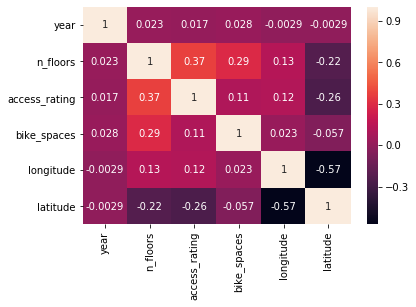

In [102]:
#see correlations
sns.heatmap(buildings.corr(), annot = True);

In [103]:
buildings.head()

year  n_floors     building_use access_type  access_rating  bike_spaces  \
924  2011         2  House/Townhouse         low            1.0          0.0   
925  2011         2  House/Townhouse         NaN            NaN          0.0   
926  2011         1  House/Townhouse         NaN            NaN          0.0   
927  2011         1  House/Townhouse         NaN            NaN          0.0   
928  2011         1  House/Townhouse         NaN            NaN          0.0   

     longitude  latitude  
924   144.9815  -37.8177  
925   144.9292  -37.7931  
926   144.9409  -37.7905  
927   144.9280  -37.7940  
928   144.9315  -37.7926

In [104]:
buildings.dtypes

year                int64
n_floors            int64
building_use       object
access_type      category
access_rating     float64
bike_spaces       float64
longitude         float64
latitude          float64
dtype: object

In [105]:
#save to csv
buildings.to_csv('./cleaned datasets/buildings_clean.csv', header = buildings.columns, index=False)

## Dataset with Landmarks & Places of Interest
"This dataset contains a description and co-ordinates of places of interest within the City of Melbourne.

Themes include: Community Use, Education Centre, Health Services, Leisure/Recreation, Mixed Use, Office, Place Of Assembly, Place of Worship, Purpose Built, Retail, Transport, Vacant Land

Sub-themes include: Art Gallery/Museum, Church, Function/Conference/Exhibition Centre, Informal Outdoor Facility (Park/Garden/Reserve), Major Sports & Recreation Facility, Office, Public Buildings, Public Hospital, Railway Station, Retail/Office/Carpark, Tertiary (University), Theatre Live"

In [106]:
landmarks = pd.read_csv('./Original CSVs/Landmarks_and_places_of_interest__including_schools__theatres__health_services__sports_facilities__places_of_worship__galleries_and_museums..csv')

In [107]:
landmarks.head()

Theme                                        Sub Theme  \
0           Transport                                  Railway Station   
1           Mixed Use                            Retail/Office/Carpark   
2   Place Of Assembly                                          Library   
3  Leisure/Recreation  Informal Outdoor Facility (Park/Garden/Reserve)   
4    Place of Worship                                           Church   

                        Feature Name                           Co-ordinates  
0  Flemington Bridge Railway Station  (-37.7881645889621, 144.939277838304)  
1              Council House 2 (CH2)  (-37.8142591432011, 144.966638432727)  
2    The Melbourne Athenaeum Library  (-37.8148855756416, 144.967291289941)  
3              Carlton Gardens South  (-37.8060684577258, 144.971266479841)  
4                  St Francis Church  (-37.8118847831837, 144.962422614541)

In [108]:
landmarks.isnull().sum()

Theme           0
Sub Theme       0
Feature Name    0
Co-ordinates    0
dtype: int64

In [109]:
#split co-ordinates into latitude and longitude columns like building data is in
split_data = landmarks['Co-ordinates'].str.strip(')').str.strip('(').str.split(', ')
landmarks['latitude'] = split_data.apply(lambda x: x[0])
landmarks['longitude'] = split_data.apply(lambda x: x[1])

In [110]:
landmarks.drop('Co-ordinates', axis = 1, inplace = True)

In [111]:
landmarks.head()

Theme                                        Sub Theme  \
0           Transport                                  Railway Station   
1           Mixed Use                            Retail/Office/Carpark   
2   Place Of Assembly                                          Library   
3  Leisure/Recreation  Informal Outdoor Facility (Park/Garden/Reserve)   
4    Place of Worship                                           Church   

                        Feature Name           latitude         longitude  
0  Flemington Bridge Railway Station  -37.7881645889621  144.939277838304  
1              Council House 2 (CH2)  -37.8142591432011  144.966638432727  
2    The Melbourne Athenaeum Library  -37.8148855756416  144.967291289941  
3              Carlton Gardens South  -37.8060684577258  144.971266479841  
4                  St Francis Church  -37.8118847831837  144.962422614541

In [113]:
#rename columns
landmarks.rename({'Theme': 'theme', 'Sub Theme': 'sub_theme', 'Feature Name': 'feature_name'}, axis =1, inplace = True)

In [114]:
landmarks.groupby(['theme', 'sub_theme'])['sub_theme'].count()

theme                                 sub_theme                                      
Community Use                         Cemetery                                            1
                                      Fire Station                                        1
                                      Government Building                                 1
                                      Police Station                                      3
                                      Public Buildings                                   13
                                      Visitor Centre                                      2
Education Centre                      Further Education                                   1
                                      Primary Schools                                     4
                                      School - Primary and Secondary Education            2
                                      Secondary Schools                               

In [115]:
landmarks.to_csv('./cleaned datasets/landmarks_clean.csv', header = landmarks.columns, index=False)

## Dataset with Bike Share Locations and capacity
### Even though this program ended in 2019, the docks were in use for the majority of years that this analysis will use
"This dataset show the historical Melbourne Bike Share docks. This program came to an end in Novemer 2019.

Contains the bike share dock locations that were deployed across Melbourne as part of the Melbourne Bike Share Program.

Melbourne Bike Share is a joint RACV/Victorian Government bicycle hire scheme. It allows commuters to hire a bike from a dock location and return it to another dock location in the city. This dataset contains the bike share dock locations and capacity across the city."

In [116]:
bikes = pd.read_csv('./Original CSVs/Bike_Share_Dock_Locations.csv')

In [117]:
bikes.head()

station_id                                               name  \
0           2           Harbour Town - Docklands Dve - Docklands   
1           6  State Library - Swanston St / Little Lonsdale ...   
2           7          Bourke Street Mall - 205 Bourke St - City   
3           8                Melbourne Uni - Tin Alley - Carlton   
4           9            RMIT - Swanston St / Franklin St - City   

    rental_method  capacity        lat         lon                  location  
0  CREDITCARD,KEY        23 -37.814022  144.939521  (-37.814022, 144.939521)  
1  CREDITCARD,KEY        11 -37.810702  144.964417  (-37.810702, 144.964417)  
2  CREDITCARD,KEY        11 -37.813088  144.967437  (-37.813088, 144.967437)  
3  CREDITCARD,KEY        19 -37.796250  144.960858   (-37.79625, 144.960858)  
4  CREDITCARD,KEY         7 -37.807699  144.963095  (-37.807699, 144.963095)

In [118]:
bikes.drop(['rental_method', 'location', 'name'], axis =1, inplace= True)

In [119]:
bikes.isnull().sum()

station_id    0
capacity      0
lat           0
lon           0
dtype: int64

In [121]:
bikes.rename({'lat': 'latitude', 'lon': 'longitude'}, axis =1, inplace = True)

In [122]:
bikes.head()

station_id  capacity   latitude   longitude
0           2        23 -37.814022  144.939521
1           6        11 -37.810702  144.964417
2           7        11 -37.813088  144.967437
3           8        19 -37.796250  144.960858
4           9         7 -37.807699  144.963095

In [123]:
bikes.to_csv('./cleaned datasets/bikes_clean.csv', header = bikes.columns, index=False)

## City Lighting
"This dataset contains information such as location, lighting type and wattage of feature lighting across City of Melbourne.

Feature lights are usually found around high profile areas of the city."

In [124]:
lights = pd.read_csv('./Original CSVs/Feature_Lighting__including_light_type__wattage_and_location_.csv')

In [125]:
lights.head()

asset_number                         asset_description  lamp_type_lupvalue  \
0       1542034  Feature Lighting - Shrine of Remembrance                13.0   
1       1348116              Feature Lighting - Docklands                 5.0   
2       1347754              Feature Lighting - Docklands                 5.0   
3       1541768                        Feature Lighting -                13.0   
4       1542387                        Feature Lighting -                13.0   

   lamp_rating_w mounting_type_lupvalue        lat         lon  \
0           70.0   Pole: Multiple Fixed -37.832430  144.972851   
1           70.0               Inground -37.819371  144.952721   
2           70.0               Inground -37.814309  144.941508   
3           35.0   Pole: Multiple Fixed -37.823777  144.947362   
4           35.0   Pole: Multiple Fixed -37.823550  144.947258   

                                    location  
0   (-37.83243026700112, 144.97285142540412)  
1    (-37.81937093721541, 144.9527211538597)  
2    (-37.81430907663625, 144.9415082516051)  
3    (-37.82377720278515, 144.9473620390991)  
4  (-37.823549964115635, 144.94725830188167)

In [126]:
lights.drop(['asset_number', 'asset_description', 'mounting_type_lupvalue', 'location'], axis = 1, inplace = True)

In [127]:
lights.isnull().sum()

lamp_type_lupvalue    1093
lamp_rating_w         4458
lat                      0
lon                      0
dtype: int64

In [128]:
lights.shape

(8564, 4)

In [130]:
lights.rename({'lat': 'latitude', 'lon': 'longitude'}, axis =1, inplace = True)

In [131]:
lights.head()

lamp_type_lupvalue  lamp_rating_w   latitude   longitude
0                13.0           70.0 -37.832430  144.972851
1                 5.0           70.0 -37.819371  144.952721
2                 5.0           70.0 -37.814309  144.941508
3                13.0           35.0 -37.823777  144.947362
4                13.0           35.0 -37.823550  144.947258

In [132]:
lights.to_csv('./cleaned datasets/lights_clean.csv', header = lights.columns, index=False)

## Street Infrastructure
"The City of Melbourne owns and maintains various objects and pieces of equipment installed on streets and roads for various purposes. This dataset includes Barbeques, Bicycle Rails, Bin Corrals, Bollards, Drinking Fountains, Floral Crate/Planter Boxs, Hoops, Horse Troughs, Information Pillars, Litter Bins, Picnic Setting, Seats."

In [148]:
street_inf = pd.read_csv('./Original CSVs/Street_furniture_including_bollards__bicycle_rails__bins__drinking_fountains__horse_troughs__planter_boxes__seats__barbecues.csv')

In [149]:
street_inf.head()

GIS_ID                                   DESCRIPTION        ASSET_CLASS  \
0  1074394  Bicycle Rails - Stainless Steel Bicycle Hoop  Outdoor Furniture   
1  1074441  Bicycle Rails - Stainless Steel Bicycle Hoop  Outdoor Furniture   
2  1074542  Bicycle Rails - Stainless Steel Bicycle Hoop  Outdoor Furniture   
3  1074589  Bicycle Rails - Stainless Steel Bicycle Hoop  Outdoor Furniture   
4  1074624  Bicycle Rails - Stainless Steel Bicycle Hoop  Outdoor Furniture   

      ASSET_TYPE    MODEL_NO                                   MODEL_DESCR  \
0  Bicycle Rails  200101-004  Bicycle Rails - Stainless Steel Bicycle Hoop   
1  Bicycle Rails  200101-004  Bicycle Rails - Stainless Steel Bicycle Hoop   
2  Bicycle Rails  200101-004  Bicycle Rails - Stainless Steel Bicycle Hoop   
3  Bicycle Rails  200101-004  Bicycle Rails - Stainless Steel Bicycle Hoop   
4  Bicycle Rails  200101-004  Bicycle Rails - Stainless Steel Bicycle Hoop   

                     DIVISION            COMPANY  \
0  Engineering Services Group  City of Melbourne   
1  Engineering Services Group  City of Melbourne   
2  Engineering Services Group  City of Melbourne   
3  Engineering Services Group  City of Melbourne   
4  Engineering Services Group  City of Melbourne   

                                       LOCATION_DESC  CONDITION_RATING  \
0  Lonsdale Street between Spring Street and Exhi...              4.00   
1  Barry Street between Leicester Street and Pelh...              3.78   
2  Wills Tower & Wills Court approximately 38m SE...              3.69   
3  Shiel Street between Dryburgh Street and Canni...              3.64   
4  Drummond Street between Queensberry Street and...              3.71   

  EVALUATION_DATE    EASTING    NORTHING  UploadDate  \
0      10/04/2019  321290.32  5813330.45  16/04/2020   
1      12/04/2019  320372.35  5814159.81  16/04/2020   
2      12/04/2019  320168.48  5813234.36  16/04/2020   
3      12/04/2019  318829.95  5814778.95  16/04/2020   
4      12/04/2019  321110.75  5813953.97  16/04/2020   

                         CoordinateLocation  
0   (-37.80994298252108, 144.9698553381076)  
1   (-37.802292402724426, 144.959638879039)  
2   (-37.81058822870216, 144.9570947832389)  
3   (-37.79641089316797, 144.9422841239329)  
4  (-37.80429145086489, 144.96797056759425)

In [150]:
street_inf.drop(['GIS_ID', 'DESCRIPTION', 'MODEL_NO', 'MODEL_DESCR', 'DIVISION', 'COMPANY',
                'LOCATION_DESC', 'EVALUATION_DATE', 'EASTING', 'NORTHING', 'UploadDate'], axis = 1, inplace = True)

In [151]:
#split coordinates into lat/long coordinate columns
split_data = street_inf['CoordinateLocation'].str.strip(')').str.strip('(').str.split(', ')
street_inf['latitude'] = split_data.apply(lambda x: x[0])
street_inf['longitude'] = split_data.apply(lambda x: x[1])

In [152]:
street_inf.drop('CoordinateLocation', axis = 1, inplace = True)

In [153]:
#rename columns to be only lowercase
street_inf.rename({'ASSET_CLASS': 'asset_class', 'ASSET_TYPE': 'feature', 'CONDITION_RATING': 'condition_rating'},
                 axis = 1, inplace = True)

In [154]:
street_inf.head()

asset_class        feature  condition_rating             latitude  \
0  Outdoor Furniture  Bicycle Rails              4.00   -37.80994298252108   
1  Outdoor Furniture  Bicycle Rails              3.78  -37.802292402724426   
2  Outdoor Furniture  Bicycle Rails              3.69   -37.81058822870216   
3  Outdoor Furniture  Bicycle Rails              3.64   -37.79641089316797   
4  Outdoor Furniture  Bicycle Rails              3.71   -37.80429145086489   

            longitude  
0   144.9698553381076  
1    144.959638879039  
2   144.9570947832389  
3   144.9422841239329  
4  144.96797056759425

In [155]:
street_inf.isnull().sum()

asset_class            0
feature                0
condition_rating    2014
latitude               0
longitude              0
dtype: int64

In [156]:
street_inf.shape

(22928, 5)

In [157]:
street_inf.asset_class.value_counts()
#drop asset class since it is all outdoor furniture

Outdoor Furniture    22928
Name: asset_class, dtype: int64

In [158]:
street_inf.drop('asset_class', axis =1, inplace = True)

In [160]:
street_inf.feature.value_counts()

Bollard                     9069
Bicycle Rails               5838
Seat                        3339
Litter Bin                  3247
Tree Guard                   451
Drinking Fountain            301
Hoop                         202
Floral Crate/Planter Box     189
Picnic Setting               167
Barbeque                      62
Information Pillar            43
Horse Trough                  19
Bin Corral                     1
Name: feature, dtype: int64

In [161]:
street_inf.head()

feature  condition_rating             latitude           longitude
0  Bicycle Rails              4.00   -37.80994298252108   144.9698553381076
1  Bicycle Rails              3.78  -37.802292402724426    144.959638879039
2  Bicycle Rails              3.69   -37.81058822870216   144.9570947832389
3  Bicycle Rails              3.64   -37.79641089316797   144.9422841239329
4  Bicycle Rails              3.71   -37.80429145086489  144.96797056759425

In [162]:
street_inf.to_csv('./cleaned datasets/street_inf_clean.csv', header = street_inf.columns, index=False)